# CS446/546 - Class Session 14 - Network inference using partial correlations

In this class session we will continue with analyzing the tumor gene expression dataset from the NIH human bladder cancer cohort (*M*=414 tumors), building on what we learned in Class Session 19 (Correlation Network).  In order to keep the analysis simple&ast;, in this notebook will restrict our analysis to a set of *N*=164 genes that are very highly expressed in bladder cancer. Using the 164 x 414 matrix of transcript abundance measurements, we will construct a network based on gene-gene partial correlation coefficients. We will also compare the distribution of partial correlation coefficients to the distribution of Pearson correlation coefficients. Do you think they will be different?  In what way would you expect them to be different?

&ast; Here, "simple" means that the covariance matrix will be nonsingular, so that we can obtain the partial correlation matrix by inversion.

Let's start by loading the two R packages that we will need for this exercise:

In [20]:
library(corpcor)  ## we will use this library for computing partial correl.

suppressPackageStartupMessages(   
library(igraph)   ## we will use this library for plotting the network
)

Read the tab-deliminted text file of gene expression measurements (rows correspond to genes, columns correspond to bladder tumor samples; the first row of the file contains the "names" of the tumor samples). As usual, you will use `read.table` with `row.names=1`. 

In [21]:
gene_matrix_for_network <- read.table("shared/bladder_cancer_genes_tcga.txt",
                                     sep="\t",
                                     header=TRUE,
                                     row.names=1)

As always, you should check using `dim` to verify that the file that you loaded has the expected dimensions (in this case, 4,473 x 414)

In [22]:
dim(gene_matrix_for_network)

[1] 4473  414

Filter the matrix `gene_matrix_for_network` to include only rows for which the row median expression level is > 12 (a reasonbly high transcript tag count since these measurements are in log2 scale); matrix should now be 164 x 414; this is not strictly necessary but will help prevent us from over-burderning the EC2 instance and it will enable us to easily compute the partial correlation matrix using the inverse of the covariance matrix.

First, compute the row-wise median expression levels, using `apply` with `MARGIN=1`:

In [23]:
gene_median_express <- apply(gene_matrix_for_network, 1, median)

Next, use array indexing `[` to make a matrix `gene_matrix_filt` that contains only the rows for which `gene_median_express > 12`:

In [24]:
gene_matrix_filt <- gene_matrix_for_network[gene_median_express > 12, ]

Use `nrow` to verify that this matrix has 164 rows:

In [25]:
N <- nrow(gene_matrix_filt)
N

[1] 164

Using the `cor` function (our friend from last class session), compute the 164 x 164 matrix of gene-gene Pearson correlation coefficients. Don't forget that `cor` computes correlations between *columns* of its matrix argument, so you will have to transpose the data matrix using the `t` function before passing it to `cor`. 

In [26]:
matrix_cor <- cor(t(gene_matrix_filt))

Use `dim` to verify that your matrix is now *N* x *N*, where *N* = 164.  (If you get 414 x 414 instead, you forgot to transpose.) This illustrates why it is good to always be checking matrix and data frame dimensions as you go through your analysis!

In [27]:
dim(matrix_cor)

[1] 164 164

Read the online help page for the function `corpcor::cor2pcor`.  What is its input object type?  What is its output object type?

In [28]:
?cor2pcor

Use the `corpcor::cor2pcor` function to compute the partial correlation matrix (note: if *N* > *M*, `cor2pcor` is not recommended; we would need to instead use `corpcor::pcor.shrink`, which uses a technique called shrinkage estimation to obtain the partial correlation matrix).

In [29]:
matrix_pcor <- corpcor::cor2pcor(matrix_cor)

Plot the histograms of the correlation coefficients (upper triangle only) and the partial correlation coefficients, on the same plot using alpha blending (refer to class session 17 exercise).

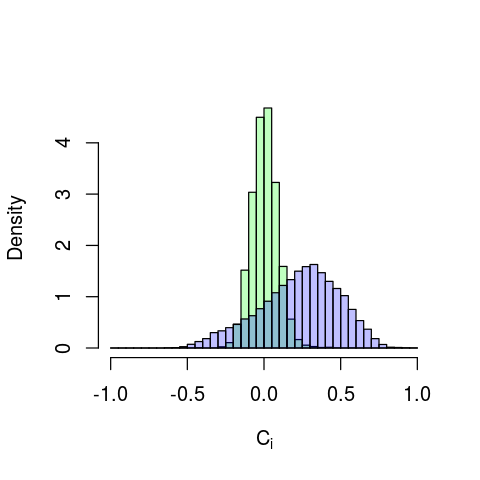

In [30]:
nbreaks <- 40
breaks <- ((0:nbreaks)-(nbreaks/2))/(nbreaks/2)
hist_cor <- hist(matrix_cor[upper.tri(matrix_cor)], breaks=breaks, plot=FALSE)
hist_pcor <- hist(matrix_pcor[upper.tri(matrix_pcor)], breaks=breaks, plot=FALSE)
plotvals <- 0.5*(breaks[1:nbreaks] + breaks[2:(nbreaks+1)])
plot(hist_pcor, col=rgb(0,1,0,1/4), xlab=expression(C[i]), main="", freq=FALSE)
plot(hist_cor, col=rgb(0,0,1,1/4), add=TRUE, freq=FALSE)
legend(0.3, 8, legend=c("cor","pcor"), fill=c(rgb(0,0,1,1/4),rgb(0,1,0,1/4)))

Fisher transform the partial correlation matrix, to get a matrix of z scores:

In [31]:
matrix_z <- 0.5*log((1+matrix_pcor)/(1-matrix_pcor))

Compute a p-value for each gene pair (upper triangle only), using the fact that sqrt(M-N-5) times the fisher Z sore should be approximately univariate normal (with zero mean) under the null hypothesis that a given gene pair's measurements (conditioned on the measurements for all the other 162 genes) are independent. (use `sqrt`, `upper.tri`, `abs`, and `pnorm`)

In [33]:
M <- ncol(gene_matrix_for_network)
pvalues <- 2*pnorm(-abs(matrix_z[upper.tri(matrix_z)])*sqrt(M-N-5))

How many gene pairs have a P value less than 0.01? (use `which` and `length`)

In [34]:
length(which(pvalues < 0.01))

[1] 706

What are the sizes of the components in the undirected graph whose edges have `P < 0.01` in the statistical test that you did?  You will need to use `arrayInd`, `cbind`, `graph_from_data_frame`, and `components` (last two of those functions are old friends from `igraph`). As always, print a summary about your graph.

In [35]:
inds_tri <- which(upper.tri(matrix_z))
inds_sig <- which(pvalues < 0.01)
graph_edge_list <- cbind(arrayInd(inds_tri[inds_sig], 
                 .dim=c(N,N)))
pcor_graph <- graph_from_data_frame(graph_edge_list, directed=FALSE)
summary(pcor_graph)
components(pcor_graph)$csize

IGRAPH a6c28de UN-- 164 706 -- 
+ attr: name (v/c)


[1] 164

Plot the graph in igraph (make sure you first set the plot options using
`igraph_options(vertex.size=1, vertex.label=NA, edge.width=0.3)`)

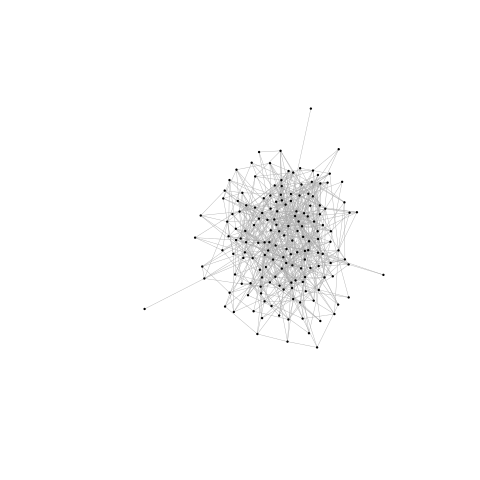

In [36]:
igraph_options(vertex.size=1, vertex.label=NA, edge.width=0.3, margin=-5)
plot(pcor_graph)

Plot the graph degree distribution on log-log scale

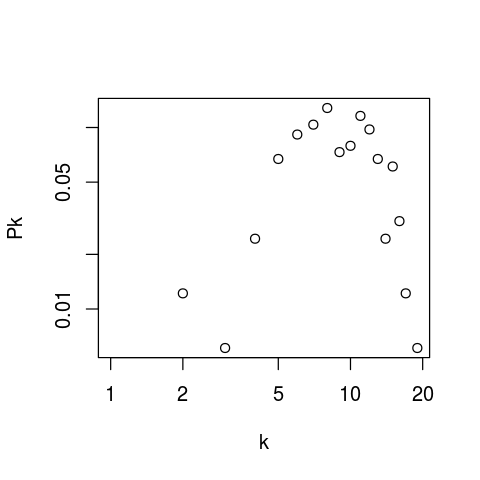

In [37]:
suppressWarnings(

    plot(degree.distribution(pcor_graph), log="xy", xlab="k", ylab="Pk")

)